# Usage

An Experiment should have:

    1. Baseline - FULL_0
    2. FULL_attack_ratio
    3. MID_attack_ratio
    4. END_attack_ratio

Place all these in a folder and call ```plot_results()``` method with ```path, model name and attack ratio``` 

# Plot Code 

In [6]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import pandas as pd


def create_results_csv(model: str, baseline: list, full: list, mid: list, end: list, save_dir: None):
    data = []
    data.extend(baseline)
    data.extend(full)
    data.extend(mid)
    data.extend(end)
    df_data = {model: data}
    index = pd.MultiIndex.from_tuples([
        ('Baseline', 'Precision'),
        ('Baseline', 'Recall'),
        ('Baseline', 'F1'),
        ('Baseline', 'Loss'),
        ('Baseline', 'Accuracy'),
        ('FULL', 'Precision'),
        ('FULL', 'Recall'),
        ('FULL', 'F1'),
        ('FULL', 'Loss'),
        ('FULL', 'Accuracy'),
        ('MID', 'Precision'),
        ('MID', 'Recall'),
        ('MID', 'F1'),
        ('MID', 'Loss'),
        ('MID', 'Accuracy'),
        ('END', 'Precision'),
        ('END', 'Recall'),
        ('END', 'F1'),
        ('END', 'Loss'),
        ('END', 'Accuracy')
    ], names=['Group', 'Metric'])
    df = pd.DataFrame(df_data, index=index)
    if save_dir:
        file_name = save_dir + model + ".csv"
        df.to_csv(file_name, index=True)
    else:
        print(df)

 
# def plot_2d(title: str, graph_type: str, baseline: list, full: list, mid: list, end: list, save_dir:str=None):
#     plt.title(title)
#     rounds = [i for i in range(len(baseline))]
#     plt.plot(rounds, baseline, label="Baseline")
#     plt.plot(rounds, full, label="FULL")
#     plt.plot(rounds, mid, label="MID")
#     plt.plot(rounds, end, label="END")
#     plt.xlabel("Federated Learning Rounds")
#     plt.ylabel(graph_type)
#     plt.legend()
#     plt.show()


# def plot_3d(title: str, graph_type: str, baseline: list, full: list, mid: list, end: list, save_dir:str=None):
#     # Assuming you have data in the following format:
#     # rounds: List of federated learning rounds
#     # baseline_accuracy: List of baseline accuracy values
#     # full_100_accuracy: List of accuracy values for FULL attack with 100% label flipping
#     # mid_50_accuracy: List of accuracy values for MID attack with 50% label flipping
#     # end_30_accuracy: List of accuracy values for END attack with 30% label flipping

# #     plt.clf()
#     fig = plt.figure(figsize=(12,8))
#     ax = fig.add_subplot(111, projection='3d')
#     rounds = [i for i in range(len(baseline))]

#     # Plot baseline accuracy
#     ax.plot(rounds, [0] * len(rounds), baseline,
#             label='Baseline', color='blue', linewidth=2)

#     # Plot FULL attack with 100% label flipping
#     ax.plot(rounds, [1] * len(rounds), full,
#             label='FULL', color='green', linewidth=2)

#     # Plot MID attack with 50% label flipping
#     ax.plot(rounds, [2] * len(rounds), mid,
#             label='MID', color='red', linewidth=2)

#     # Plot END attack with 30% label flipping
#     ax.plot(rounds, [3] * len(rounds), end,
#             label='END', color='purple', linewidth=2)

#     # Set labels
#     ax.set_xlabel('Federated Learning Rounds')
#     # ax.set_ylabel('Label Flipping Intensity')
#     ax.set_zlabel(graph_type, rotation=90)
#     ax.set_yticks([0, 1, 2, 3])
#     # ax.set_yticklabels(['Baseline', 'FULL', 'MID', 'END'])
#     ax.set_title(title)

#     # Adjust layout to make room for the z-axis label
#     ax.set_box_aspect(aspect=None, zoom=0.8)

#     # Add legend
#     ax.legend()
#     plt.tight_layout()
#     # Show the 3D plot
#     if save_dir:
#         plt.savefig(save_dir+title+graph_type+".png", bbox_inches='tight')
#     plt.show()

def plot_3d(title: str, loss_graph: dict, accuracy_graph: dict, save_dir: str = None):
    # Assuming you have data in the following format:
    # rounds: List of federated learning rounds
    # baseline_accuracy: List of baseline accuracy values
    # full_100_accuracy: List of accuracy values for FULL attack with 100% label flipping
    # mid_50_accuracy: List of accuracy values for MID attack with 50% label flipping
    # end_30_accuracy: List of accuracy values for END attack with 30% label flipping

    #     plt.clf()
    fig = plt.figure(figsize=(12, 8))
    fig.suptitle(title)

    ax1 = fig.add_subplot(122, projection='3d')
    rounds = [i for i in range(len(accuracy_graph["baseline"]))]

    # Plot baseline accuracy
    ax1.plot(rounds, [0] * len(rounds), accuracy_graph["baseline"],
             label='Baseline', color='blue', linewidth=2)

    # Plot FULL attack with 100% label flipping
    ax1.plot(rounds, [1] * len(rounds), accuracy_graph["full"],
             label='FULL', color='green', linewidth=2)

    # Plot MID attack with 50% label flipping
    ax1.plot(rounds, [2] * len(rounds), accuracy_graph["mid"],
             label='MID', color='red', linewidth=2)

    # Plot END attack with 30% label flipping
    ax1.plot(rounds, [3] * len(rounds), accuracy_graph["end"],
             label='END', color='purple', linewidth=2)

    # Set labels
    ax1.set_xlabel('Federated Learning Rounds')
    # ax.set_ylabel('Label Flipping Intensity')
    ax1.set_zlabel(accuracy_graph["graph_type"], rotation=90)
    ax1.set_yticks([])
    # ax.set_yticklabels(['Baseline', 'FULL', 'MID', 'END'])
    ax1.set_title(accuracy_graph["graph_type"])

    # Adjust layout to make room for the z-axis label
    ax1.set_box_aspect(aspect=None, zoom=0.8)

    # Add legend
    ax1.legend()
    ax1

    # LOSS GRAPH
    ax2 = fig.add_subplot(121, projection='3d')
    rounds = [i for i in range(len(loss_graph["baseline"]))]

    # Plot baseline accuracy
    ax2.plot(rounds, [0] * len(rounds), loss_graph["baseline"],
             label='Baseline', color='blue', linewidth=2)

    # Plot FULL attack with 100% label flipping
    ax2.plot(rounds, [1] * len(rounds), loss_graph["full"],
             label='FULL', color='green', linewidth=2)

    # Plot MID attack with 50% label flipping
    ax2.plot(rounds, [2] * len(rounds), loss_graph["mid"],
             label='MID', color='red', linewidth=2)

    # Plot END attack with 30% label flipping
    ax2.plot(rounds, [3] * len(rounds), loss_graph["end"],
             label='END', color='purple', linewidth=2)

    # Set labels
    ax2.set_xlabel('Federated Learning Rounds')
    # ax.set_ylabel('Label Flipping Intensity')
    ax2.set_zlabel(loss_graph["graph_type"], rotation=90)
    ax2.set_yticks([])
    # ax.set_yticklabels(['Baseline', 'FULL', 'MID', 'END'])
    ax2.set_title(loss_graph["graph_type"])

    # Adjust layout to make room for the z-axis label
    ax2.set_box_aspect(aspect=None, zoom=0.8)

    # Add legend
    ax2.legend()

    plt.tight_layout()
    # Show the 3D plot
    if save_dir:
        plt.savefig(save_dir+title+".png", bbox_inches='tight')
    plt.show()


def plot_other_metrics(title: str, metrics_centralized: dict, save_dir: str = None):
    num_classes = len(metrics_centralized["precision"])
    precision_list = [metrics_centralized["precision"][i][1]
                      for i in range(num_classes)]
    recall_list = [metrics_centralized["recall"][i][1]
                   for i in range(num_classes)]
    f1_list = [metrics_centralized["f1"][i][1] for i in range(num_classes)]
    p= round(precision_list[-1], 4)
    r= round(recall_list[-1], 4)
    f1= round(f1_list[-1], 4)
    print(title, "Precision", round(statistics.mean(precision_list), 4), "Recall", round(
        statistics.mean(recall_list), 4), "F1", round(statistics.mean(f1_list), 4))

    fig, axs = plt.subplots(2, 2, figsize=(8, 6))
    plt.suptitle(title)

    # Precision
    # plt.subplot(131)
    axs[0, 0].bar(range(num_classes), precision_list, color='blue')
    axs[0, 0].set_xlabel('FL Round')
    axs[0, 0].set_ylabel('Precision')
    axs[0, 0].set_title('Precision')

    # Recall
    # plt.subplot(132)
    axs[0, 1].bar(range(num_classes), recall_list, color='green')
    axs[0, 1].set_xlabel('FL Round')
    axs[0, 1].set_ylabel('Recall')
    axs[0, 1].set_title('Recall')

    # F1
    # plt.subplot(133)
    axs[1, 0].bar(range(num_classes), f1_list, color='orange')
    axs[1, 0].set_xlabel('FL Round')
    axs[1, 0].set_ylabel('F1-Score')
    axs[1, 0].set_title('F1-Score')

    # plt.subplot(1)
    sns.heatmap(metrics_centralized['confusion_matrix'][-1][1],
                fmt="d", cmap="Blues", annot=True,
                xticklabels=range(num_classes),
                yticklabels=range(num_classes), ax=axs[1, 1])
    axs[1, 1].set_title("Confusion Matrix")
    axs[1, 1].set_xlabel("Predicted")
    axs[1, 1].set_ylabel("True")

    plt.tight_layout()
    if save_dir:
        plt.savefig(save_dir+title+"-metrics.png")
    plt.show()
    return p, r, f1


def plot_results(dir: str, model: str, attack_ratio: int, plot_mode: str = '3d', save_dir: str = None):
    title_dict = {"MLP": "Multi Layer Perceptron",
                  "SCNN": "Simple Convolution Neural Network",
                  "LGR": "Logistic Regression",
                  "LSVC": "SVC - Linear Kernel",
                  "XGB": "XGBoost",
                  "RF": "Random Forest",
                  "LSTM": "LSTM",
                  "RNN": "RNN"}

    # plot_method = None
    # if plot_mode == '2d':
    #     plot_method = plot_2d
    # elif plot_mode == '3d':
    #     plot_method = plot_3d

    title = title_dict[model] + " - " + \
        str(attack_ratio) + "%" + " Adverserial Clients"

    # Baseline
    file = open(dir + model + "_FULL_0.pkl", 'rb')
    baseline_result = pickle.load(file)
    file.close()
    baseline_loss = baseline_result['history'].losses_centralized
    baseline_accuracy = baseline_result['history'].metrics_centralized['accuracy']
    p,r,f1 = plot_other_metrics(model + " Baseline - No Adverserial Clients",
                       baseline_result['history'].metrics_centralized, save_dir)
    baseline_loss_list = [baseline_loss[i][1]
                          for i in range(len(baseline_loss))]
    baseline_accuracy_list = [baseline_accuracy[i][1]
                              for i in range(len(baseline_accuracy))]
    loss = round(baseline_loss_list[-1], 4)
    accuracy = round(baseline_accuracy_list[-1], 4)
    print("baseline", "Loss", loss)
    print("baseline", "Accuracy", accuracy)
    baseline_csv_metrics = [p, r, f1, loss, accuracy]

    # Temporal - FULL
    file = open(dir + model + "_FULL_" +
                str(attack_ratio) + ".pkl", 'rb')
    full_mal = pickle.load(file)
    file.close()
    full_mal_loss = full_mal['history'].losses_centralized
    full_mal_accuracy = full_mal['history'].metrics_centralized['accuracy']
    p,r,f1 = plot_other_metrics(title + " (Full)",
                       full_mal['history'].metrics_centralized, save_dir)
    full_mal_loss_list = [full_mal_loss[i][1]
                          for i in range(len(full_mal_loss))]
    full_mal_accuracy_list = [full_mal_accuracy[i][1]
                              for i in range(len(full_mal_accuracy))]
    loss = round(full_mal_loss_list[-1], 4)
    accuracy =  round(full_mal_accuracy_list[-1], 4)
    print(model, str(attack_ratio), "FULL",
          "Loss", loss)
    print(model, str(attack_ratio), "FULL", "Accuracy",
         accuracy)
    full_csv_metrics = [p, r, f1, loss, accuracy]

    # Temporal - MID
    file = open(dir + model + "_MID_" +
                str(attack_ratio) + ".pkl", 'rb')
    mid_mal = pickle.load(file)
    file.close()
    mid_mal_loss = mid_mal['history'].losses_centralized
    mid_mal_accuracy = mid_mal['history'].metrics_centralized['accuracy']
    p,r,f1 = plot_other_metrics(
        title + " (MID)", mid_mal['history'].metrics_centralized, save_dir)
    mid_mal_loss_list = [mid_mal_loss[i][1] for i in range(len(mid_mal_loss))]
    mid_mal_accuracy_list = [mid_mal_accuracy[i][1]
                             for i in range(len(mid_mal_accuracy))]
    loss =  round(mid_mal_loss_list[-1], 4)
    accuracy = round(mid_mal_accuracy_list[-1], 4)
    print(model, str(attack_ratio), "MID",
          "Loss",loss)
    print(model, str(attack_ratio), "MID", "Accuracy",
          accuracy)
    mid_csv_metrics = [p, r, f1, loss, accuracy]

    # Temporal - END
    file = open(dir + model + "_END_" +
                str(attack_ratio) + ".pkl", 'rb')
    end_mal = pickle.load(file)
    file.close()
    end_mal_loss = end_mal['history'].losses_centralized
    end_mal_accuracy = end_mal['history'].metrics_centralized['accuracy']
    p,r,f1 = plot_other_metrics(
        title + " (END)", end_mal['history'].metrics_centralized, save_dir)
    end_mal_loss_list = [end_mal_loss[i][1] for i in range(len(end_mal_loss))]
    end_mal_accuracy_list = [end_mal_accuracy[i][1]
                             for i in range(len(end_mal_accuracy))]
    loss = round(end_mal_loss_list[-1], 4)
    accuracy = round(end_mal_accuracy_list[-1], 4)
    print(model, str(attack_ratio), "END",
          "Loss", loss)
    print(model, str(attack_ratio), "END", "Accuracy",
          accuracy)
    end_csv_metrics = [p, r, f1, loss, accuracy]

    loss_graph = {"graph_type": "Loss",
                  "baseline": baseline_loss_list,
                  "full": full_mal_loss_list,
                  "mid": mid_mal_loss_list,
                  "end": end_mal_loss_list
                  }

    # plot_method(title, "Loss", baseline_loss_list, full_mal_loss_list,
    #             mid_mal_loss_list, end_mal_loss_list, save_dir)

    accuracy_graph = {"graph_type": "Accuracy",
                      "baseline": baseline_accuracy_list,
                      "full": full_mal_accuracy_list,
                      "mid": mid_mal_accuracy_list,
                      "end": end_mal_accuracy_list
                      }

    # plot_method(title, "Accuracy", baseline_accuracy_list,
    #             full_mal_accuracy_list, mid_mal_accuracy_list, end_mal_accuracy_list, save_dir)
    plot_3d(title=title, loss_graph=loss_graph,
            accuracy_graph=accuracy_graph, save_dir=save_dir)
    create_results_csv(model=model, baseline=baseline_csv_metrics, full=full_csv_metrics, mid=mid_csv_metrics, end=end_csv_metrics, save_dir=save_dir)
    

# Label Shifting

## Multi Layer Perceptron

LGR Baseline - No Adverserial Clients Precision 0.775 Recall 0.774 F1 0.7623


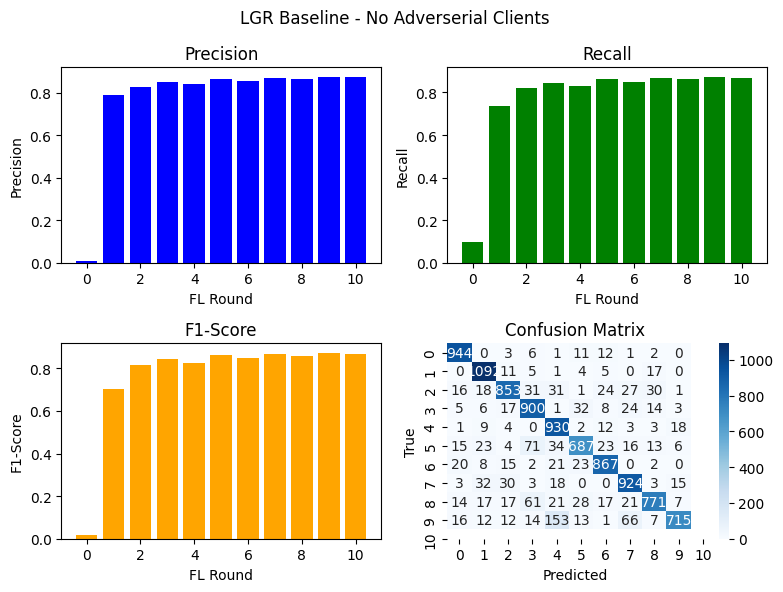

baseline Loss 0.4984
baseline Accuracy 0.8683
Logistic Regression - 25% Adverserial Clients (Full) Precision 0.59 Recall 0.5382 F1 0.4914


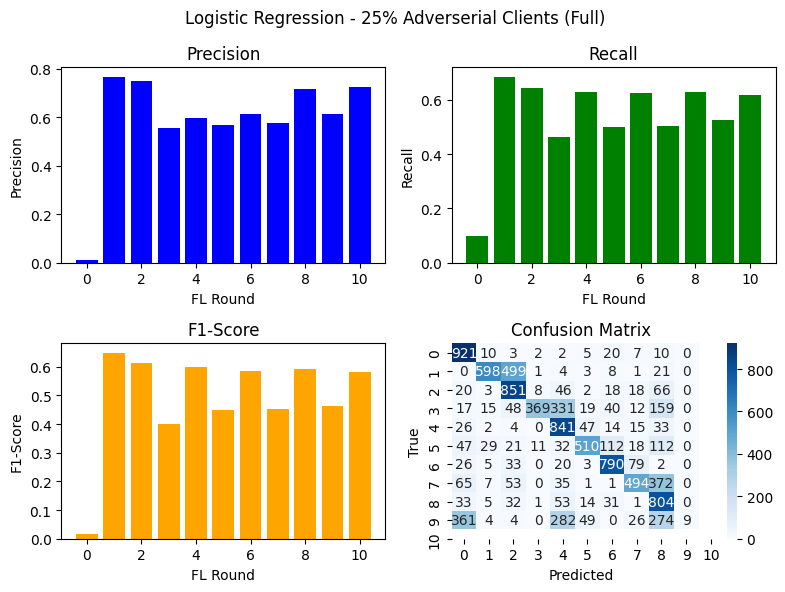

LGR 25 FULL Loss 1.1729
LGR 25 FULL Accuracy 0.6187
Logistic Regression - 25% Adverserial Clients (MID) Precision 0.7566 Recall 0.7463 F1 0.7314


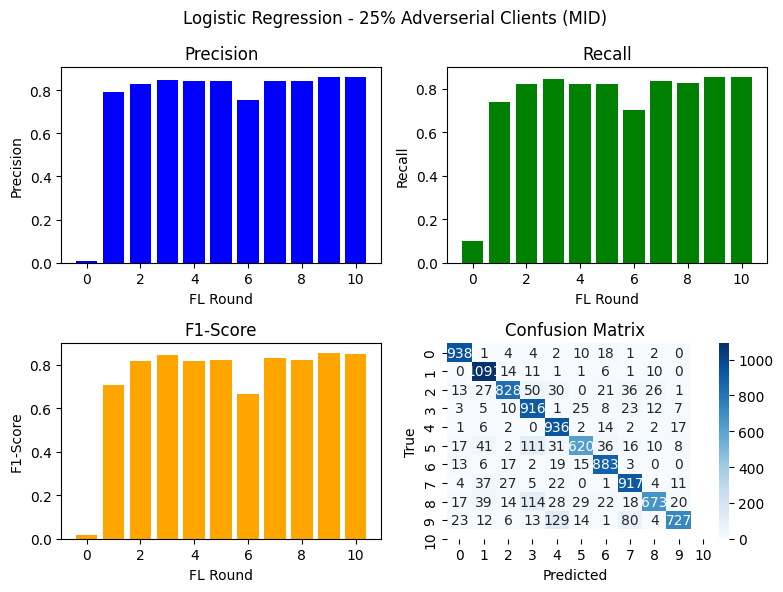

LGR 25 MID Loss 0.6154
LGR 25 MID Accuracy 0.8529
Logistic Regression - 25% Adverserial Clients (END) Precision 0.7677 Recall 0.7588 F1 0.7449


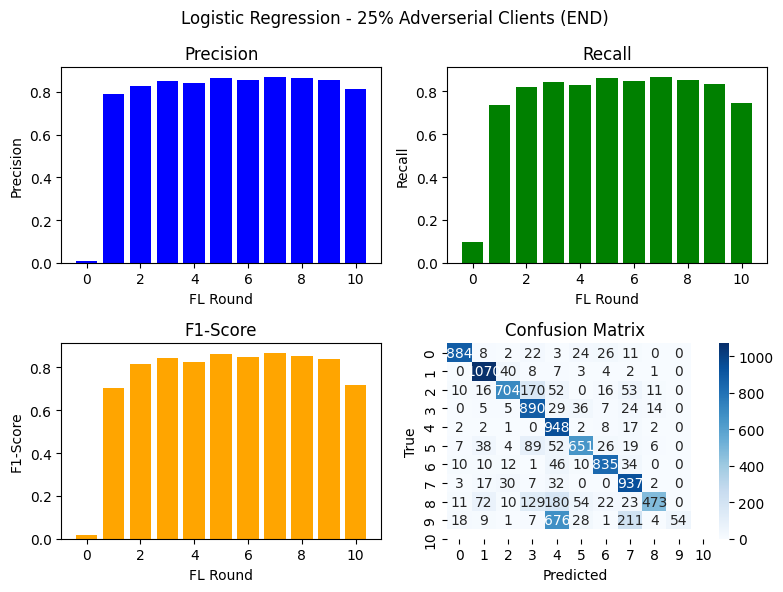

LGR 25 END Loss 0.9167
LGR 25 END Accuracy 0.7446


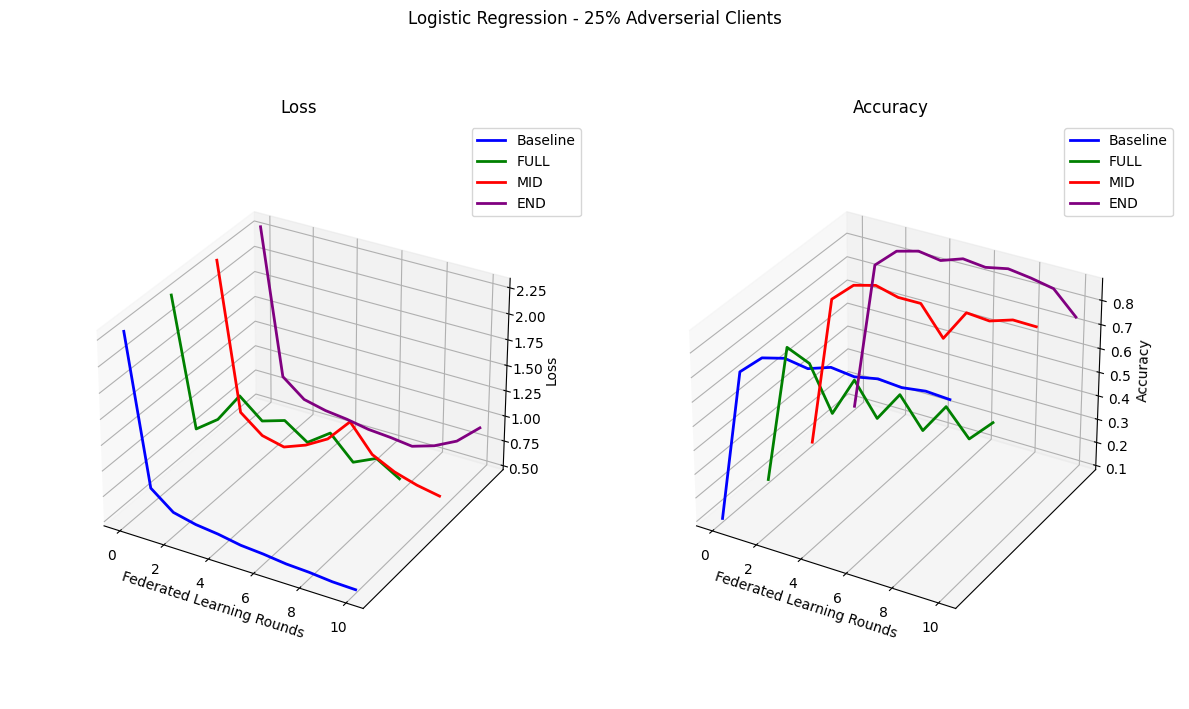

                       LGR
Group    Metric           
Baseline Precision  0.8725
         Recall     0.8683
         F1         0.8669
         Loss       0.4984
         Accuracy   0.8683
FULL     Precision  0.7233
         Recall     0.6187
         F1         0.5831
         Loss       1.1729
         Accuracy   0.6187
MID      Precision  0.8597
         Recall     0.8529
         F1         0.8504
         Loss       0.6154
         Accuracy   0.8529
END      Precision  0.8124
         Recall     0.7446
         F1         0.7161
         Loss       0.9167
         Accuracy   0.7446


In [9]:
plot_results("runs0/LF/", "LGR", attack_ratio=25)